In [1]:
# import neccessary packages
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2
!pip uninstall -y xgboost
!pip install xgboost==1.7.6
!pip install --upgrade imbalanced-learn


Found existing installation: scikit-learn 1.6.0
Uninstalling scikit-learn-1.6.0:
  Successfully uninstalled scikit-learn-1.6.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 109.6 MB/s eta 0:00:00
Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 9.7 MB/s eta 0:00:00


In [2]:
# deploy neccessary packages/ modules
import xgboost
print(xgboost.__version__)
import sklearn
print(sklearn.__version__)

1.7.6
1.5.2


In [3]:
# deploy neccessary packages/ modules
import pandas as pd
import numpy as np
import os
import re
import logging
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, average_precision_score, roc_curve, f1_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
!pip install shap
import shap
import scipy.stats as stats
!pip install missingno
import missingno as msno
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.dummy import DummyClassifier


In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# change directory
os.chdir("/content/drive/MyDrive/FAINT")
print(os.getcwd())

/content/drive/MyDrive/FAINT


In [6]:
# define random_seed
random_number = 120

In [7]:
# define data path and upload cleaned dataset
file_path ='datain/cleaned_faint.csv'
df = pd.read_csv(file_path)

In [8]:
# define features and targets

# define features
X= df.drop(columns=['VVR_group']).copy()

# define target --> identical across samples
y=df['VVR_group']

In [9]:
# define training and test set -- %20 test and %20 training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,  random_state=random_number)

In [10]:
# define final training and test samples including main features + somatosensory

X_train_s = X_train.drop(columns=['donor_id',
                                  'VVR_sum',
                                  'Condition',
                                  'Gender'
                          ])

X_test_s = X_test.drop(columns=['donor_id',
                                'VVR_sum',
                                'Condition',
                                'Gender']
                          )

In [11]:

# define final training and test samples including main features (without somatosensory amplification)
X_train_m = X_train_s.drop(columns=['SSAS_sum'])

X_test_m = X_test_s.drop(columns=['SSAS_sum'])


In [12]:
# identify features with numeric characteristics -- main sample
numeric_features_m = X_train_m.select_dtypes(include=['int64', 'float64']).columns.tolist()

# identify features with numeric characteristics -- somatosensory sample
numeric_features_s = X_train_s.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [13]:
# define stratified k-fold for inner and outer loop
cv_inner = StratifiedKFold(n_splits=5,
                             shuffle=True, random_state=random_number)
cv_outer = StratifiedKFold(n_splits=10,
                             shuffle=True, random_state=random_number)

# define a dictionary for utilized metrics
scores={ "Recall":"recall", "Precision": "precision", "Accuracy":"accuracy","F1": "f1", "AUC":"roc_auc", "AUC-PR": make_scorer(average_precision_score, needs_proba=True)}


In [14]:
# create a function to store model validation results - outer loop
def score_dict(scores_cv):
  validation_results={}
  for key, value in scores_cv.items():
    if key not in ['fit_time', 'score_time']:
      validation_results[key]={'mean_val': np.mean(value), 'std_val': np.std(value)}
  val_df = pd.DataFrame(validation_results)
  return val_df

In [15]:
# define a function produce predicted values and scores based on tuned model
def predict_evaluate(X, y, model, best_model, sample):
  y_pred = best_model.predict(X)
  y_pred_prob = best_model.predict_proba(X)

  results= {
        'model': model,
        'sample': sample,
        'recall': recall_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'accuracy': accuracy_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'roc_auc': roc_auc_score(y, y_pred_prob[:,1]),
        'auc_pr':average_precision_score(y, y_pred_prob[:,1])
        }

  return results, y_pred


In [16]:
# create a function to iterate training process for each pipeline

model_scores=[]
def train_model (pipe_name, grid_name, model_name, X_train, y_train, X_test, y_test):

  # apply gridsearch - inner loop
  grid_search = GridSearchCV(pipe_name, grid_name,
                    scoring = scores,
                    refit ='F1',
                    cv=cv_inner )

  # report validation scores - outer loop
  scores_outer = cross_validate(grid_search,
                                 X_train,
                                 y_train,
                                 scoring=scores,
                                 cv=cv_outer,
                                 n_jobs=-1)

  # store validation results
  validation_score = score_dict(scores_outer)

  # fit the model
  grid_search.fit(X_train, y_train)

  # define best model
  best_model = grid_search.best_estimator_

  # report best parameters and cv results
  print("Best parameters: {}".format(grid_search.best_params_))
  print("Best f1 score -inner loop: {}".format(grid_search.best_score_))
  print("Outer loop f1 score", validation_score['test_F1'])

  # keep best parameters:
  best_p = grid_search.best_params_

  # keep cv results as dataset
  cv_res =pd.DataFrame(grid_search.cv_results_)
  cv_res['model_type']= model_name

  # predict and evaluate for test sets
  results_test, y_test_pred  = predict_evaluate(X_test, y_test, model_name, best_model, "Test")

  # construct confusion matrix for test set
  cm = confusion_matrix(y_test, y_test_pred)

  # report f1 score for test sets
  print("f1_test: {:.2f}".format(results_test['f1']))

  # append scores
  model_scores.append(results_test)

  return model_scores, cv_res, best_model, cm, best_p, validation_score

In [17]:
# preprocessors for baseline dataset
preprocessor_m = ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), numeric_features_m)
    ]
)


In [18]:
# define pipelines for each model - oversampling matches

pipe_dummy_str = Pipeline([
    ('preprocess', preprocessor_m),
    ('classifier', DummyClassifier( random_state=random_number, strategy='stratified'))
    ])

pipe_svc_ros = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy='auto', random_state=random_number)),
    ('preprocess', preprocessor_m),
    ('classifier', SVC( random_state=random_number, probability=True))
    ])

pipe_svc_smote = Pipeline([
    ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_number)),
    ('preprocess', preprocessor_m),
    ('classifier', SVC( random_state=random_number, probability=True))
    ])


pipe_xgb_ros = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy='auto', random_state=random_number)),
    ('classifier', XGBClassifier(random_state=random_number))
    ])

pipe_xgb_smote = Pipeline([
    ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_number)),
    ('classifier', XGBClassifier(random_state=random_number))
    ])

pipe_rft_ros = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy='auto', random_state=random_number)),
    ('classifier', RandomForestClassifier(random_state=random_number))
    ])

pipe_rft_smote = Pipeline([
    ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_number)),
    ('classifier', RandomForestClassifier(random_state=random_number))
    ])


pipe_mlp_ros = Pipeline([
    ('oversample', RandomOverSampler(sampling_strategy='auto', random_state=random_number)),
    ('preprocess', preprocessor_m),
    ('classifier', MLPClassifier(early_stopping=True, random_state=random_number))
    ])

pipe_mlp_smote = Pipeline([
    ('oversample', SMOTE(sampling_strategy='auto',  k_neighbors=3, random_state=random_number)),
    ('preprocess', preprocessor_m),
    ('classifier', MLPClassifier(early_stopping=True, random_state=random_number))
    ])


In [19]:
# define hyperparameter space  for each model:

grid_param_dummy= {'classifier__random_state':[ random_number ]
                 }


grid_param_svc= {'classifier__kernel':[ 'rbf' ]
                 }

grid_param_xgb ={'classifier__max_depth':[ 1, 2, 3],
                 'classifier__subsample':[ 0.5, 0.7],
                 'classifier__colsample_bytree': [0.5, 0.7],
                 'classifier__learning_rate':[0.001, 0.01],
                  'classifier__reg_alpha':[1, 5, 7, 10],

                 }


grid_param_rft = {'classifier__max_depth':[1, 2, 3, 5],
                  'classifier__min_samples_split':[0.1, 0.2, 0.3],
                  'classifier__min_samples_leaf':[2, 3, 5],
                  'classifier__criterion':['gini', 'entropy'],
                  'classifier__n_estimators':[100, 200]
                  }


grid_param_mlp ={'classifier__hidden_layer_sizes':[ (64,32), (64), (32),(16)],
                 'classifier__activation':['relu', 'tanh'],
                 'classifier__solver':['adam'],
                 'classifier__batch_size':[32, 64],
                 'classifier__alpha':[ 1,  2, 5, 10]
                 }



In [20]:
# fit the models for dummy classifier
score_master, df_dummy_str, best_dummy_str, cm_dummy_str, para_dummy_str, val_dummy_str = train_model (pipe_dummy_str,
                                                                                                        grid_param_dummy,
                                                                                                        "dummy_str",
                                                                                                        X_train_m,
                                                                                                        y_train,
                                                                                                        X_test_m,
                                                                                                        y_test
                                                                                                        )



Best parameters: {'classifier__random_state': 120}
Best f1 score -inner loop: 0.32476190476190475
Outer loop f1 score mean_val    0.322857
std_val     0.091394
Name: test_F1, dtype: float64
f1_test: 0.41


In [21]:
# fit the models for mlp
score_master, df_mlp_ros, best_mlp_ros, cm_mlp_ros, para_mlp_ros, val_mlp_ros = train_model (pipe_mlp_ros,
                                                                                              grid_param_mlp,
                                                                                              "mlp_ros",
                                                                                              X_train_m,
                                                                                              y_train,
                                                                                              X_test_m,
                                                                                              y_test
                                                                                              )

print("________________________________________________________________________")

score_master, df_mlp_smote, best_mlp_smote, cm_mlp_smote, para_mlp_smote, val_mlp_smote= train_model (pipe_mlp_smote,
                                                                                                      grid_param_mlp,
                                                                                                      "mlp_smote",
                                                                                                      X_train_m,
                                                                                                      y_train,
                                                                                                      X_test_m,
                                                                                                      y_test
                                                                                                      )

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__alpha': 1, 'classifier__batch_size': 32, 'classifier__hidden_layer_sizes': 32, 'classifier__solver': 'adam'}
Best f1 score -inner loop: 0.4922832756571358
Outer loop f1 score mean_val    0.481895
std_val     0.042515
Name: test_F1, dtype: float64
f1_test: 0.47
________________________________________________________________________
Best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 1, 'classifier__batch_size': 32, 'classifier__hidden_layer_sizes': 16, 'classifier__solver': 'adam'}
Best f1 score -inner loop: 0.5035675908016334
Outer loop f1 score mean_val    0.462937
std_val     0.058617
Name: test_F1, dtype: float64
f1_test: 0.48


In [22]:
# fit the models for svc
score_master, df_svc_ros, best_svc_ros, cm_svc_ros, para_svc_ros, val_svc_ros = train_model (pipe_svc_ros,
                                                                                              grid_param_svc,
                                                                                              "svc_ros",
                                                                                              X_train_m,
                                                                                              y_train,
                                                                                              X_test_m,
                                                                                              y_test
                                                                                            )

print("________________________________________________________________________")

score_master, df_svc_smote, best_svc_smote, cm_svc_smote, para_svc_smote, val_svc_smote = train_model(pipe_svc_smote,
                                                                                                      grid_param_svc,
                                                                                                      "svc_smote",
                                                                                                      X_train_m,
                                                                                                      y_train,
                                                                                                      X_test_m,
                                                                                                      y_test
                                                                                                      )

Best parameters: {'classifier__kernel': 'rbf'}
Best f1 score -inner loop: 0.42323639733462787
Outer loop f1 score mean_val    0.391948
std_val     0.083931
Name: test_F1, dtype: float64
f1_test: 0.33
________________________________________________________________________
Best parameters: {'classifier__kernel': 'rbf'}
Best f1 score -inner loop: 0.4341581932279607
Outer loop f1 score mean_val    0.447535
std_val     0.128261
Name: test_F1, dtype: float64
f1_test: 0.41


In [23]:
# fit the models for xgb
score_master, df_xgb_ros, best_xgb_ros, cm_xgb_ros, para_xgb_ros, val_xgb_ros= train_model(pipe_xgb_ros,
                                                                                           grid_param_xgb,
                                                                                           "xgb_ros",
                                                                                            X_train_m,
                                                                                            y_train,
                                                                                            X_test_m,
                                                                                            y_test
                                                                                           )

print("________________________________________________________________________")

score_master, df_xgb_smote, best_xgb_smote, cm_xgb_smote, para_xgb_smote, val_xgb_smote= train_model(pipe_xgb_smote,
                                                                                                     grid_param_xgb,
                                                                                                     "xgb_smote",
                                                                                                      X_train_m,
                                                                                                      y_train,
                                                                                                      X_test_m,
                                                                                                      y_test
                                                                                                    )

Best parameters: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.001, 'classifier__max_depth': 1, 'classifier__reg_alpha': 10, 'classifier__subsample': 0.5}
Best f1 score -inner loop: 0.5056013908645488
Outer loop f1 score mean_val    0.433552
std_val     0.123080
Name: test_F1, dtype: float64
f1_test: 0.36
________________________________________________________________________
Best parameters: {'classifier__colsample_bytree': 0.7, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__reg_alpha': 7, 'classifier__subsample': 0.5}
Best f1 score -inner loop: 0.49035695794316486
Outer loop f1 score mean_val    0.461369
std_val     0.155440
Name: test_F1, dtype: float64
f1_test: 0.33


In [24]:
# fit the models for rft
score_master, df_rft_ros, best_rft_ros, cm_rft_ros, para_rft_ros, val_rft_ros= train_model(pipe_rft_ros,
                                                                                           grid_param_rft,
                                                                                           "rft_ros",
                                                                                            X_train_m,
                                                                                            y_train,
                                                                                            X_test_m,
                                                                                            y_test
                                                                                          )


print("________________________________________________________________________")

score_master, df_rft_smote, best_rft_smote, cm_rft_smote, para_rft_smote, val_rft_smote = train_model(pipe_rft_smote,
                                                                                                     grid_param_rft,
                                                                                                     "rft_smote",
                                                                                                      X_train_m,
                                                                                                      y_train,
                                                                                                      X_test_m,
                                                                                                      y_test
                                                                                                    )

Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 0.3, 'classifier__n_estimators': 100}
Best f1 score -inner loop: 0.4799032396988136
Outer loop f1 score mean_val    0.352661
std_val     0.131358
Name: test_F1, dtype: float64
f1_test: 0.36
________________________________________________________________________


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 0.3, 'classifier__n_estimators': 100}
Best f1 score -inner loop: 0.5024434649842998
Outer loop f1 score mean_val    0.452618
std_val     0.115544
Name: test_F1, dtype: float64
f1_test: 0.48


In [25]:
# create list to report best parameters and cv results
cv_scores_list = [df_dummy_str,
                  df_svc_ros, df_svc_smote,
                  df_xgb_ros, df_xgb_smote,
                  df_mlp_ros, df_mlp_smote,
                  df_rft_ros, df_rft_smote
                  ]
parameter_list = [para_dummy_str,
                  para_svc_ros, para_svc_smote,
                  para_xgb_ros, para_xgb_smote,
                  para_mlp_ros, para_mlp_smote,
                  para_rft_ros, para_rft_smote
                  ]


In [26]:
# append validation  of the inner loop
score_df_cv = pd.DataFrame()
for i in range(0, 9):
  score_df_cv= pd.concat([score_df_cv,cv_scores_list[i].loc[cv_scores_list[i]['params']==parameter_list[i], ['mean_test_Recall',
                                                                                                             'mean_test_Precision',
                                                                                                             'mean_test_Accuracy',
                                                                                                             'mean_test_F1',
                                                                                                             'mean_test_AUC',
                                                                                                             'mean_test_AUC-PR'
                                                                                                             ]
                                                            ]
                          ], ignore_index=True)
# report
print("___________________Validation scores -- inner loop of gridsearch__________")
score_df_cv.head(15)

___________________Validation scores -- inner loop of gridsearch__________


,mean_test_Recall,mean_test_Precision,mean_test_Accuracy,mean_test_F1,mean_test_AUC,mean_test_AUC-PR
0,0.304167,0.348352,0.590306,0.324762,0.515720,0.334017
1,0.454167,0.408148,0.606463,0.423236,0.617172,0.491305
2,0.516667,0.383677,0.573810,0.434158,0.627828,0.487346
3,0.570000,0.457532,0.635714,0.505601,0.628434,0.507488
4,0.518333,0.473784,0.659949,0.490357,0.637601,0.506387
5,0.695833,0.382981,0.528486,0.492283,0.616995,0.469178
6,0.681667,0.407505,0.553401,0.503568,0.626035,0.485403
7,0.494167,0.483981,0.652126,0.479903,0.628308,0.523970
8,0.532500,0.483102,0.660289,0.502443,0.626869,0.481361


In [27]:
# define a list to store model names
model_names=['dummy_classifier','svc_ros', 'svc_smote', 'xgb_ros', 'xgb_smote', 'mlp_ros', 'mlp_smote', 'rft_ros', 'rft_smote']

In [28]:
print("_____________Validation scores -- outer loop of gridsearch______________")

i=0
for item in [val_dummy_str,
             val_svc_ros, val_svc_smote,
             val_xgb_ros, val_xgb_smote,
             val_mlp_ros, val_mlp_smote,
             val_rft_ros, val_rft_smote
             ]:
  print("________________________",model_names[i],"______________________________________________")
  print(item)
  i=i+1

_____________Validation scores -- outer loop of gridsearch______________
________________________ dummy_classifier ______________________________________________
          test_Recall  test_Precision  test_Accuracy   test_F1  test_AUC  \
mean_val     0.305357        0.342857       0.585833  0.322857  0.512973   
std_val      0.089089        0.094761       0.060797  0.091394  0.066166   

          test_AUC-PR  
mean_val     0.338510  
std_val      0.024252  
________________________ svc_ros ______________________________________________
          test_Recall  test_Precision  test_Accuracy   test_F1  test_AUC  \
mean_val     0.416071        0.400227       0.590667  0.391948  0.631808   
std_val      0.133643        0.103838       0.076301  0.083931  0.105009   

          test_AUC-PR  
mean_val     0.536164  
std_val      0.084237  
________________________ svc_smote ______________________________________________
          test_Recall  test_Precision  test_Accuracy   test_F1  test_AUC  

In [29]:
# create a dataframe to report models` test scores
score_df = pd.DataFrame(score_master)

print("______________________________Test scores _______________________________")
score_df.head(15)

______________________________Test scores _______________________________


,model,sample,recall,precision,accuracy,f1,roc_auc,auc_pr
0,dummy_str,Test,0.40,0.421053,0.629032,0.410256,0.569048,0.361969
1,mlp_ros,Test,0.80,0.333333,0.419355,0.470588,0.482143,0.358368
2,mlp_smote,Test,0.70,0.368421,0.516129,0.482759,0.504762,0.320372
3,svc_ros,Test,0.35,0.318182,0.548387,0.333333,0.509524,0.396488
4,svc_smote,Test,0.55,0.323529,0.483871,0.407407,0.522619,0.381713
5,xgb_ros,Test,0.45,0.300000,0.483871,0.360000,0.450595,0.302219
6,xgb_smote,Test,0.30,0.375000,0.612903,0.333333,0.501190,0.413464
7,rft_ros,Test,0.40,0.333333,0.548387,0.363636,0.483333,0.348288
8,rft_smote,Test,0.55,0.423077,0.612903,0.478261,0.559524,0.394405


In [30]:
# comparison models with smote  -- across class labels
y_pred_mlp_smote= best_mlp_smote.predict(X_test_m)
y_pred_mlp_ros= best_mlp_ros.predict(X_test_m)
y_pred_svc_smote= best_svc_smote.predict(X_test_m)
y_pred_rft_smote= best_rft_smote.predict(X_test_m)
y_pred_dummy= best_dummy_str.predict(X_test_m)

print("RFT-s",classification_report(y_test, y_pred_rft_smote))
print('__________________________________________________________')
print("MLP-s",classification_report(y_test, y_pred_mlp_smote))
print('__________________________________________________________')
print("MLP-r",classification_report(y_test, y_pred_mlp_ros))
print('__________________________________________________________')
print("SVC-s",classification_report(y_test, y_pred_svc_smote))
print('__________________________________________________________')
print("Dummy",classification_report(y_test, y_pred_dummy))
print('__________________________________________________________')

RFT-s               precision    recall  f1-score   support

           0       0.75      0.64      0.69        42
           1       0.42      0.55      0.48        20

    accuracy                           0.61        62
   macro avg       0.59      0.60      0.59        62
weighted avg       0.64      0.61      0.62        62

__________________________________________________________
MLP-s               precision    recall  f1-score   support

           0       0.75      0.43      0.55        42
           1       0.37      0.70      0.48        20

    accuracy                           0.52        62
   macro avg       0.56      0.56      0.51        62
weighted avg       0.63      0.52      0.53        62

__________________________________________________________
MLP-r               precision    recall  f1-score   support

           0       0.71      0.24      0.36        42
           1       0.33      0.80      0.47        20

    accuracy                           0.42   

In [31]:
# for MLP with smote --> identify cases with correct predictions
X_test['Performance_mlp']=(y_pred_mlp_smote==y_test).astype(str)
X_test.loc[X_test['Performance_mlp']=="True", 'Performance_mlp'] = 'correct'
X_test.loc[X_test['Performance_mlp']=="False", 'Performance_mlp'] = 'incorrect'


In [32]:
# for RFT with smote --> identify cases with correct predictions
X_test['Performance_rft']=(y_pred_rft_smote==y_test).astype(str)
X_test.loc[X_test['Performance_rft']=="True", 'Performance_rft'] = 'correct'
X_test.loc[X_test['Performance_rft']=="False", 'Performance_rft'] = 'incorrect'

In [34]:
# recall the threshold used to split VVR classes (will be used for graph)
mean_threshold = df['VVR_sum'].mean()

In [35]:
print(mean_threshold)

39.34313725490196


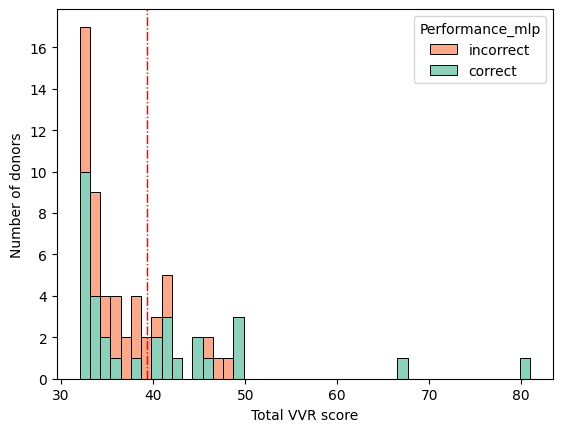

In [36]:
# check model performance across distribution of total VVR score - mlp with smote
correctness_color= {"incorrect": "#fc8d62", "correct": "#66c2a5"}


sns.histplot(
    data=X_test,
    x='VVR_sum',
    hue='Performance_mlp',
    bins=44,
    multiple="stack",
    linewidth=.7,
    palette=correctness_color,
    hue_order=["incorrect", "correct"]
)
plt.axvline(x=mean_threshold,
            color='red',
            linestyle='-.',
            linewidth=1)

plt.ylabel("Number of donors")
plt.xlabel("Total VVR score")
plt.show()

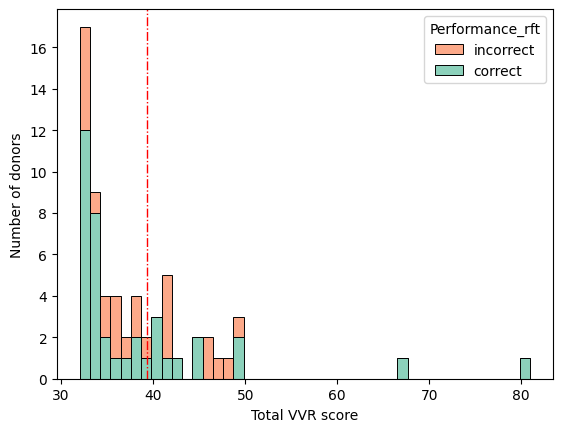

In [37]:
# check model performance across distribution of total VVR score - rft with smote

sns.histplot(
    data=X_test,
    x='VVR_sum',
    hue='Performance_rft',
    bins=44,
    multiple="stack",
    linewidth=.7,
    palette=correctness_color,
    hue_order=["incorrect", "correct"]
)
plt.axvline(x=mean_threshold,
            color='red',
            linestyle='-.',
            linewidth=1)

plt.ylabel("Number of donors")
plt.xlabel("Total VVR score")
plt.show()

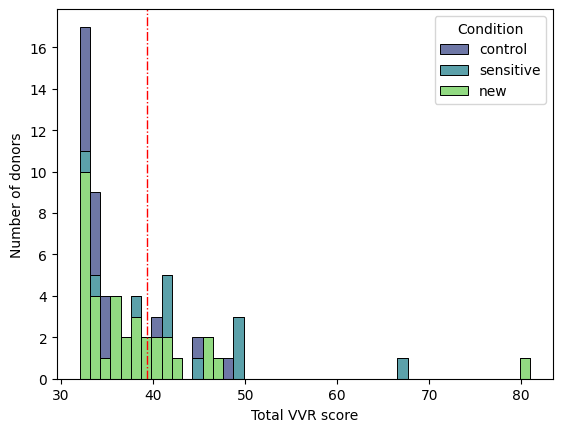

In [39]:
# plot distirbution of total VVR score in test set by donor type
palette = {"control": "#3e4a89", "sensitive": "#26828e", "new":"#6ece58" }

sns.histplot(
    data=X_test,
    x='VVR_sum',
    hue='Condition',
    bins=44,
    multiple="stack",
    linewidth=.7,
    palette=palette,
    hue_order=['control', 'sensitive', 'new']
)
plt.axvline(x=mean_threshold,
            color='red',
            linestyle='-.',
            linewidth=1)

plt.ylabel("Number of donors")
plt.xlabel("Total VVR score")

plt.show()

In [40]:
# define a function to produce confusion matrix
def conf_matrix_plt(cm, title):
    cm_fig, ax = plt.subplots(figsize=(6, 4))
    cm_fig = ConfusionMatrixDisplay(confusion_matrix=cm)
    cm_fig.plot(cmap="Blues", ax=ax)
    cm_fig.ax_.set_yticklabels(['low VVR', 'high VVR'],fontsize = 11)
    cm_fig.ax_.set_xticklabels(['low VVR', 'high VVR'],fontsize = 11)
    cm_fig.ax_.set_ylabel("True labels",fontsize =12)
    cm_fig.ax_.set_xlabel("Predicted labels",fontsize =12)
    cm_fig.ax_.set_title(title, fontsize =12)
    for text in cm_fig.ax_.texts:
      text.set_color("black")



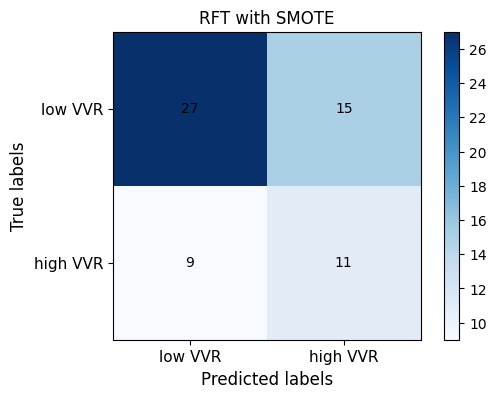

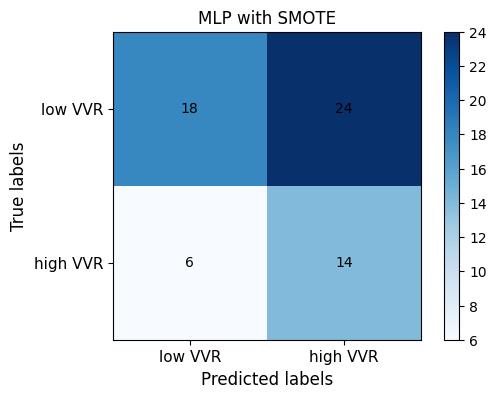

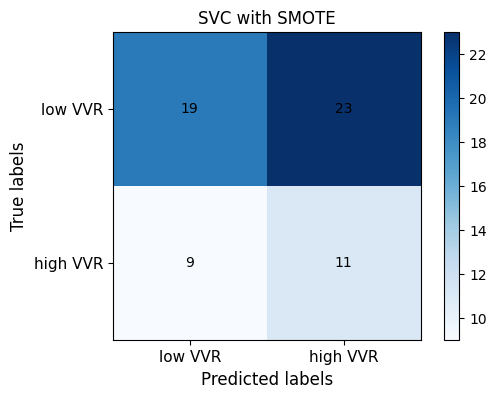

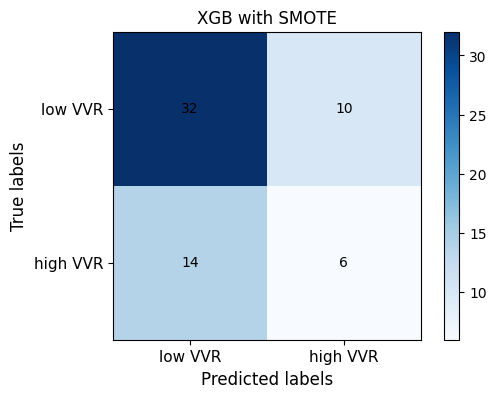

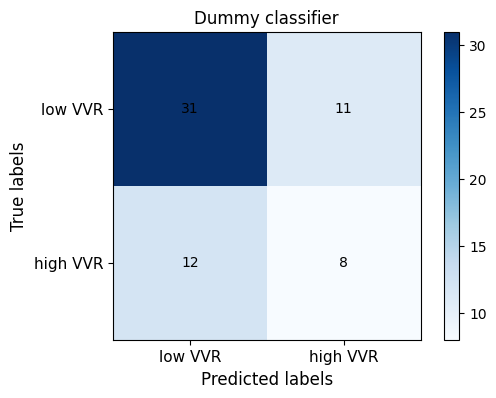

In [41]:
# report confusion matrix
conf_matrix_plt(cm_rft_smote, "RFT with SMOTE")
conf_matrix_plt(cm_mlp_smote, "MLP with SMOTE")
conf_matrix_plt(cm_svc_smote, "SVC with SMOTE")
conf_matrix_plt(cm_xgb_smote, "XGB with SMOTE")
conf_matrix_plt(cm_dummy_str, "Dummy classifier")


In [42]:
# preprocessors for extended dataset
preprocessor_s= ColumnTransformer(
    transformers=[
        ('numeric', MinMaxScaler(), numeric_features_s)
    ]
)

In [43]:
# define pipelines for extended dataset
pipe_rft_som = Pipeline([
    ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_number)),
    ('classifier', RandomForestClassifier(random_state=random_number))
    ])

pipe_mlp_som= Pipeline([
    ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_number)),
    ('preprocess', preprocessor_s),
    ('classifier', MLPClassifier(early_stopping=True, random_state=random_number))
    ])

pipe_xgb_som= Pipeline([
    ('oversample', SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=random_number)),
    ('preprocess', preprocessor_s),
    ('classifier', XGBClassifier( random_state=random_number))
    ])

In [44]:
# define hyperparameter space for models with somatosensory amplificiaton --> parameter spaces are identical across datasets
grid_rft_som = {'classifier__max_depth':[1, 2, 3, 5],
                  'classifier__min_samples_split':[0.1, 0.2, 0.3],
                  'classifier__min_samples_leaf':[2, 3, 5],
                  'classifier__criterion':['gini', 'entropy'],
                  'classifier__n_estimators':[100, 200]
                  }

grid_mlp_som = {'classifier__hidden_layer_sizes':[ (64,32), (64), (32),(16)],
                 'classifier__activation':['relu', 'tanh'],
                 'classifier__solver':['adam'],
                 'classifier__batch_size':[32, 64],
                 'classifier__alpha':[ 1, 2, 5, 10]
                 }

grid_xgb_som ={'classifier__max_depth':[ 1, 2, 3],
                 'classifier__subsample':[ 0.5, 0.7],
                 'classifier__colsample_bytree': [0.5, 0.7],
                 'classifier__learning_rate':[0.001, 0.01],
                 'classifier__reg_alpha':[1, 5, 7, 10]
                 }



In [45]:
# train the mlp-smote on the extended dataset

score_master, df_som_mlp, best_som_mlp, cm_som_mlp, para_som_mlp, val_som_mlp= train_model (pipe_mlp_som,
                                                                                           grid_mlp_som,
                                                                                           "som_mlp",
                                                                                            X_train_s,
                                                                                            y_train,
                                                                                            X_test_s,
                                                                                            y_test
                                                                                             )

Best parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 5, 'classifier__batch_size': 32, 'classifier__hidden_layer_sizes': 32, 'classifier__solver': 'adam'}
Best f1 score -inner loop: 0.5329795708730333
Outer loop f1 score mean_val    0.431942
std_val     0.106809
Name: test_F1, dtype: float64
f1_test: 0.43


In [46]:
# train the rft-smote on the extended dataset

score_master, df_som_rft, best_som_rft, cm_som_rft, para_som_rft, val_som_rft= train_model (pipe_rft_som,
                                                                                           grid_rft_som,
                                                                                           "som_rft",
                                                                                            X_train_s,
                                                                                            y_train,
                                                                                            X_test_s,
                                                                                            y_test
                                                                                             )

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 0.3, 'classifier__n_estimators': 100}
Best f1 score -inner loop: 0.5033789214415348
Outer loop f1 score mean_val    0.440909
std_val     0.141312
Name: test_F1, dtype: float64
f1_test: 0.49


In [47]:
# train the xgb-smote on the extended dataset
score_master, df_som_xgb, best_som_xgb, cm_som_xgb, para_som_xgb, val_som_xgb= train_model (pipe_xgb_som,
                                                                                           grid_xgb_som,
                                                                                           "som_xgb",
                                                                                            X_train_s,
                                                                                            y_train,
                                                                                            X_test_s,
                                                                                            y_test
                                                                                             )

Best parameters: {'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 1, 'classifier__reg_alpha': 5, 'classifier__subsample': 0.5}
Best f1 score -inner loop: 0.48810457516339867
Outer loop f1 score mean_val    0.446640
std_val     0.142532
Name: test_F1, dtype: float64
f1_test: 0.40


In [48]:
# create list to report best parameters and cv results
cv_scores_list = [df_som_rft, df_som_mlp, df_som_xgb]
parameter_list = [para_som_rft, para_som_mlp, para_som_xgb]

# append validation  of the inner loop
score_som_cv = pd.DataFrame()
for i in range(0, 3):
  score_som_cv= pd.concat([score_som_cv,cv_scores_list[i].loc[cv_scores_list[i]['params']==parameter_list[i], ['mean_test_Recall',
                                                                                                              'mean_test_Precision',
                                                                                                              'mean_test_Accuracy',
                                                                                                              'mean_test_F1',
                                                                                                              'mean_test_AUC',
                                                                                                              'mean_test_AUC-PR'
                                                                                                              ]
                                                            ]
                          ], ignore_index=True)
# report
print("___________________Validation scores -- inner loop of gridsearch__________")
score_som_cv.head(8)

___________________Validation scores -- inner loop of gridsearch__________


,mean_test_Recall,mean_test_Precision,mean_test_Accuracy,mean_test_F1,mean_test_AUC,mean_test_AUC-PR
0,0.545000,0.473836,0.655952,0.503379,0.652525,0.513323
1,0.834167,0.395407,0.516667,0.532980,0.638535,0.475062
2,0.494167,0.493209,0.668027,0.488105,0.644899,0.531324


In [49]:
# report outer loop scores of trained models on the extended dataset
print("___________________Validation scores RFT-- outer loop of gridsearch__________")
print(val_som_rft)
print("___________________Validation scores MLP -- outer loop of gridsearch__________")
print(val_som_mlp)
print("___________________Validation scores XGB -- outer loop of gridsearch__________")
print(val_som_xgb)

___________________Validation scores RFT-- outer loop of gridsearch__________
          test_Recall  test_Precision  test_Accuracy   test_F1  test_AUC  \
mean_val     0.482143        0.419473       0.615333  0.440909  0.608968   
std_val      0.185920        0.121213       0.094935  0.141312  0.119750   

          test_AUC-PR  
mean_val     0.529693  
std_val      0.119280  
___________________Validation scores MLP -- outer loop of gridsearch__________
          test_Recall  test_Precision  test_Accuracy   test_F1  test_AUC  \
mean_val     0.608929        0.358885       0.524667  0.431942  0.580456   
std_val      0.263228        0.052322       0.077190  0.106809  0.073339   

          test_AUC-PR  
mean_val     0.463946  
std_val      0.088137  
___________________Validation scores XGB -- outer loop of gridsearch__________
          test_Recall  test_Precision  test_Accuracy   test_F1  test_AUC  \
mean_val     0.455357        0.459512       0.631833  0.446640  0.624527   
std_val   

In [50]:
# report test scores of the models on extended dataset
print("______________________________Test scores _______________________________")
pd.DataFrame(score_master).tail(3)

______________________________Test scores _______________________________


,model,sample,recall,precision,accuracy,f1,roc_auc,auc_pr
9,som_mlp,Test,0.70,0.311111,0.403226,0.430769,0.382143,0.279318
10,som_rft,Test,0.55,0.440000,0.629032,0.488889,0.552381,0.376800
11,som_xgb,Test,0.35,0.466667,0.661290,0.400000,0.522619,0.376715


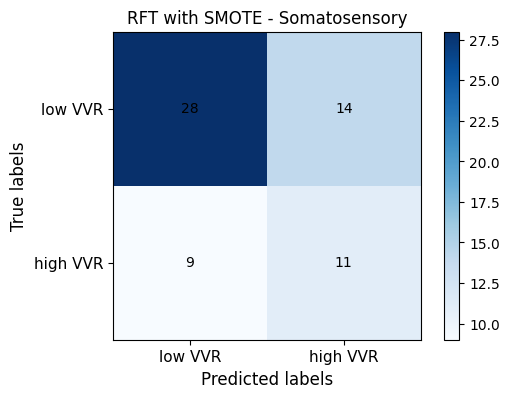

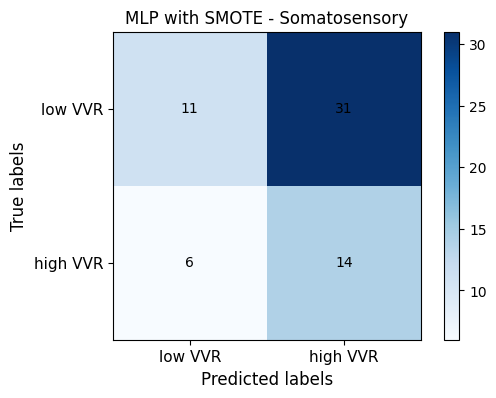

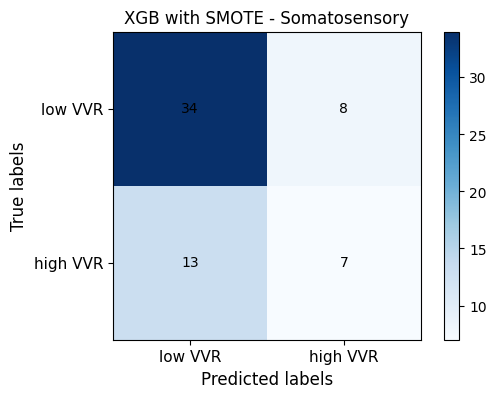

In [51]:
# confusion matrix for models on extended dataset
conf_matrix_plt(cm_som_rft, "RFT with SMOTE - Somatosensory")
conf_matrix_plt(cm_som_mlp, "MLP with SMOTE - Somatosensory")
conf_matrix_plt(cm_som_xgb, "XGB with SMOTE - Somatosensory")

In [52]:
# performance of models on extended dataset by classes
y_pred_som_rft= best_som_rft.predict(X_test_s)
print("Somatosensory- random forest")
print(classification_report(y_test, y_pred_som_rft))
print("____________________________________________________________________________")
y_pred_som_mlp= best_som_mlp.predict(X_test_s)
print("Somatosensory- mlp")
print(classification_report(y_test, y_pred_som_mlp))
print("____________________________________________________________________________")
y_pred_som_xgb = best_som_xgb.predict(X_test_s)
print("Somatosensory- xgb")
print(classification_report(y_test, y_pred_som_xgb))

Somatosensory- random forest
              precision    recall  f1-score   support

           0       0.76      0.67      0.71        42
           1       0.44      0.55      0.49        20

    accuracy                           0.63        62
   macro avg       0.60      0.61      0.60        62
weighted avg       0.65      0.63      0.64        62

____________________________________________________________________________
Somatosensory- mlp
              precision    recall  f1-score   support

           0       0.65      0.26      0.37        42
           1       0.31      0.70      0.43        20

    accuracy                           0.40        62
   macro avg       0.48      0.48      0.40        62
weighted avg       0.54      0.40      0.39        62

____________________________________________________________________________
Somatosensory- xgb
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        42
           1    

In [53]:
# define a function to produce subgroup predictions
def subgroup_prediction (model, sample, variable, group):
  index= X_test[X_test[variable]==group].index.to_list()
  X_test_g = sample.loc[index].copy()
  y_test_g = y_test.loc[index].copy()
  y_pred_g = model.predict(X_test_g)
  return y_pred_g, y_test_g

In [54]:
# store prediction and test values for each group of condition variable
y_pred1, y_test1 =subgroup_prediction (best_som_rft, X_test_s, 'Condition', 'control')
y_pred2, y_test2 =subgroup_prediction (best_som_rft, X_test_s, 'Condition', 'sensitive')
y_pred3, y_test3 =subgroup_prediction (best_som_rft, X_test_s, 'Condition', 'new')

y_pred4, y_test4 =subgroup_prediction (best_mlp_smote, X_test_m, 'Condition', 'control')
y_pred5, y_test5 =subgroup_prediction (best_mlp_smote, X_test_m, 'Condition', 'sensitive')
y_pred6, y_test6 =subgroup_prediction (best_mlp_smote, X_test_m, 'Condition', 'new')


# create sets to easily access to prediction and test values
y_pred_cond=[y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6 ]
y_test_cond=[y_test1, y_test2, y_test3, y_test4, y_test5, y_test6]

______________Somatosensory with RFT___________________


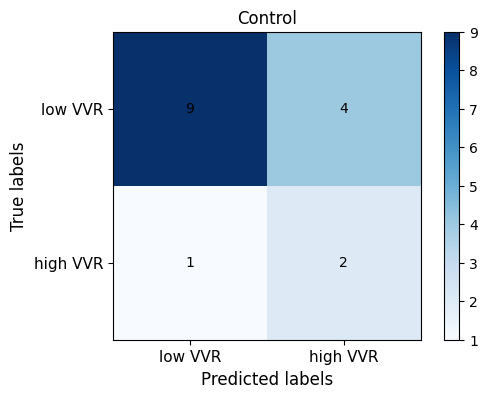

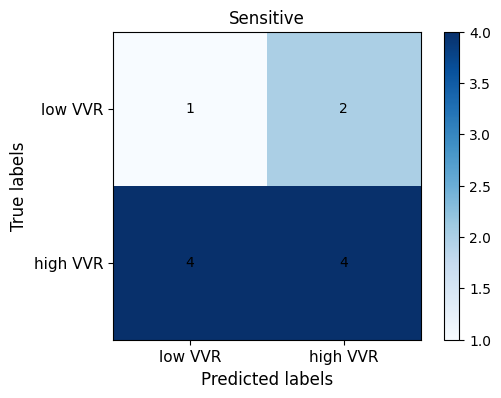

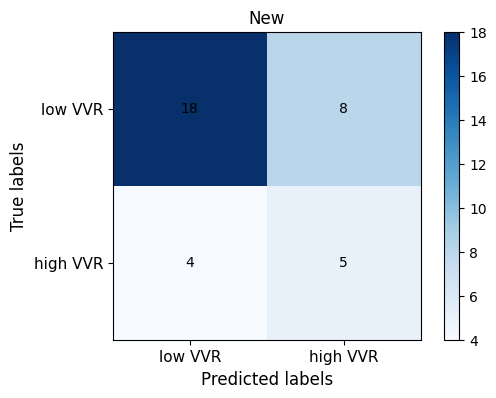

In [55]:
# use for loop to produce confusion matrixes - RFT
print("______________Somatosensory with RFT___________________")
for i in range(0,3):
  cm = confusion_matrix (y_test_cond[i], y_pred_cond[i])
  if i ==0:
    conf_matrix_plt (cm, "Control")
  elif i==1:
    conf_matrix_plt (cm, "Sensitive")
  else:
    conf_matrix_plt (cm, "New")


______________MLP with Smote__________________


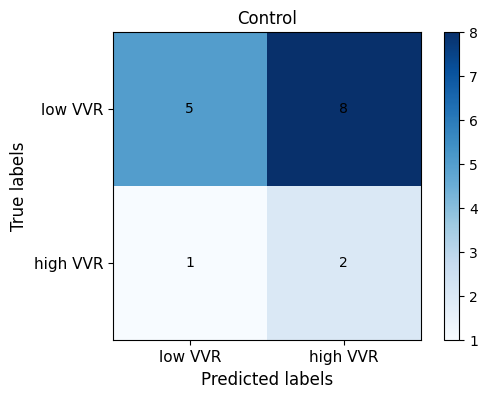

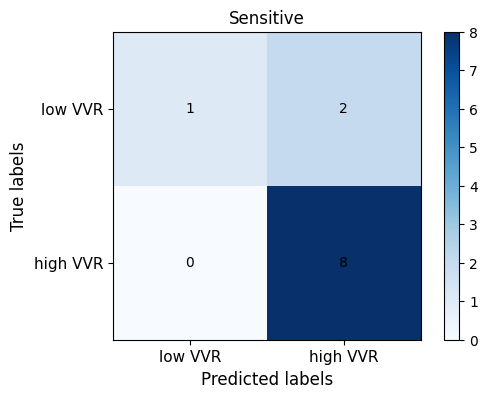

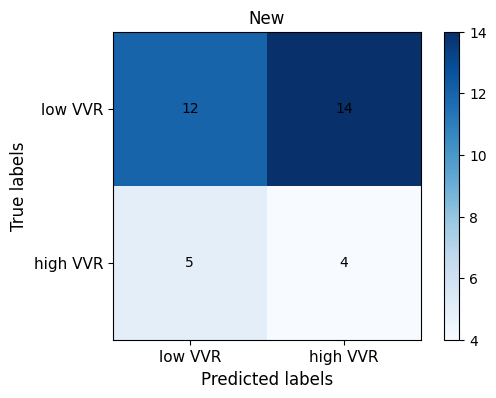

In [56]:
# use for loop to produce confusion matrixes - MLP
print("______________MLP with Smote__________________")
for i in range(3,6):
  cm = confusion_matrix (y_test_cond[i], y_pred_cond[i])
  if i ==3:
    conf_matrix_plt (cm, "Control")
  elif i==4:
    conf_matrix_plt (cm, "Sensitive")
  else:
    conf_matrix_plt (cm, "New")


In [57]:
# define a function to produce shap values
def produce_shap_tree(X, pipe, display):

 # extract pipeline
  pipe_model = pipe.named_steps['classifier']

  # define shap kernel
  execute = shap.TreeExplainer(pipe_model)
  shap_values = execute.shap_values(X)
  shap.summary_plot(shap_values[:,:,1], X, max_display=display)
  shap_df=pd.DataFrame(shap_values[:,:,1], columns=X.columns)
  return shap_df

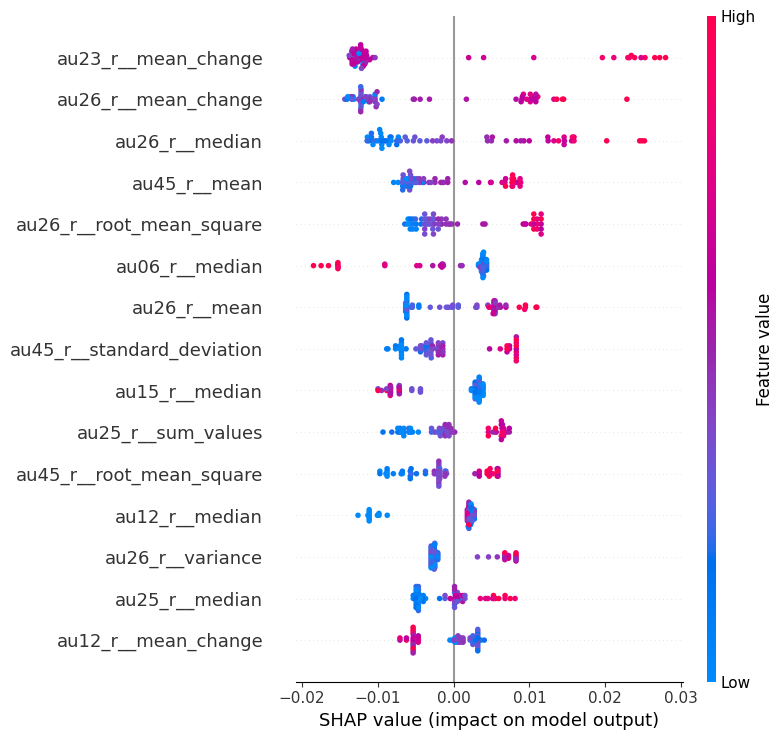

In [58]:
# plot shap values -  15 most important features
shap_rft_15=produce_shap_tree(X_test_s, best_som_rft, 15)

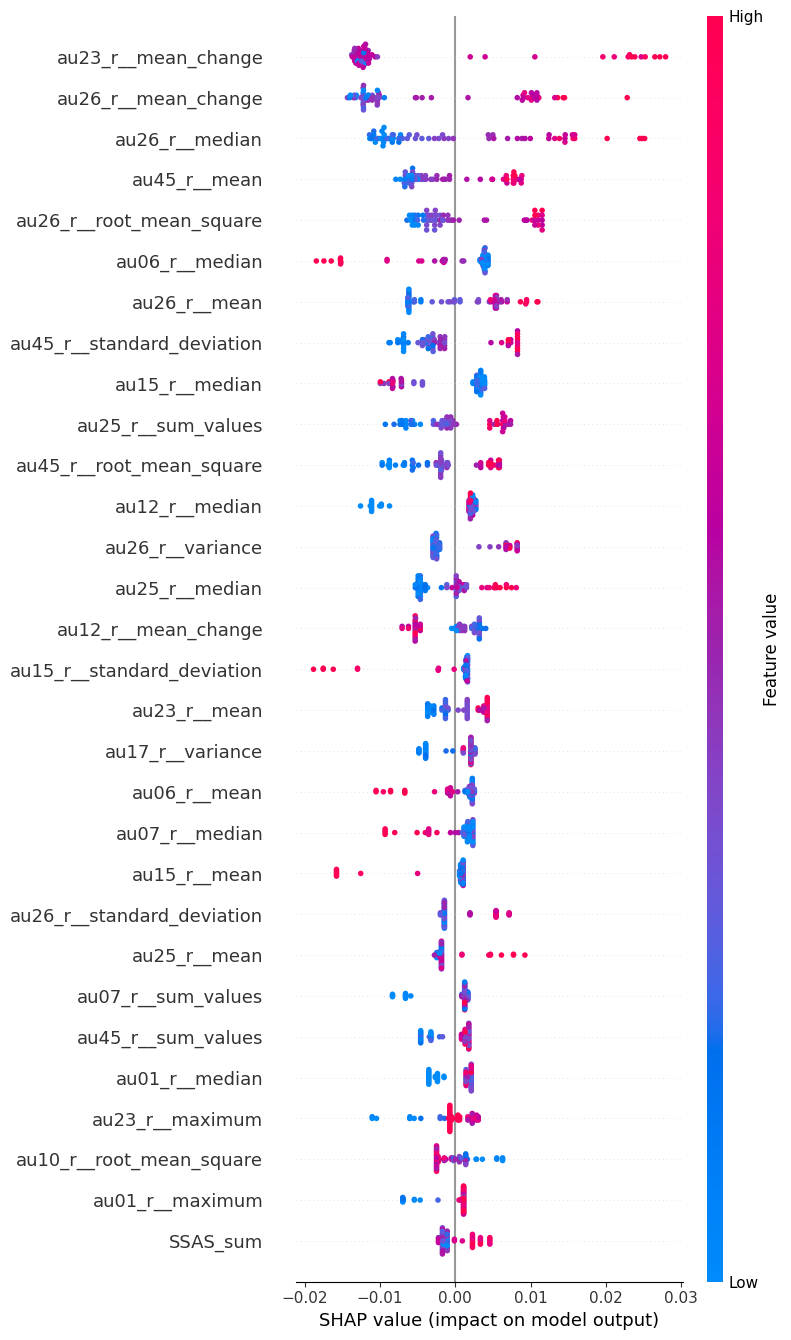

In [59]:
# plot shap values -  30 most important features
shap_rft_30=produce_shap_tree(X_test_s, best_som_rft, 30)